## Explanation of Problem Addressed

The credit card fraud detection dataset is made of about 30 features which are the result of a PCA Dimensionality reduction, and can be found [here](https://www.kaggle.com/mlg-ulb/creditcardfraud)

The target of this dataset is the Class variable, encoded as 0 when the transaction is not fraudulent, and 1 when the transaction is fraudulent. 

The dataset presents an import caracteristic: it is highly imbalanced, meaning that the observations for class 0 are drastically higher than the ones for class 1, leading to false interpretation of performance metrics.

We started by running our usual models, first on the imbalanced dataset, and as expected, the predictions for class 0 are very accurately guessed while the predictions for class 1 very poorly are. 

The given sampling strategies were applied on different models -

  - Undersampling
  - Oversampling
  - SMOTE oversampling
  - Penalized algorithm

The models below were applied to each sampling strategy presented above.
  - XGBoost
  - Logistic Regression
  - Gaussian Naive Bayes.
  - Support Vector Machine
  - Random Forest

The following were the scores calculated for each sampling strategy: 
  - Accuracy
  - Precision
  - Recall
  - F1 Measure

In [2]:
# warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("deprecated", DeprecationWarning)

# data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# modelling
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize, StandardScaler, RobustScaler, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from xgboost import XGBRegressor

# scoring
from sklearn.metrics import roc_auc_score, mean_absolute_error, classification_report, r2_score

# sampling strategies
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# Load and visualize the dataset

In [3]:
# load dataset from local directory
# warning: you should have the .csv file in the correct directory
df = pd.read_csv('creditcard.csv')

In [4]:
# first five rows
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# how many features and instances
df.shape

(284807, 31)

In [6]:
# check if null values
df.isnull().sum().max()

0

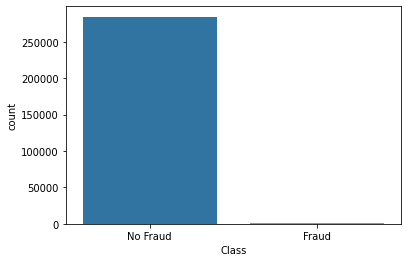

In [7]:
# target class count discrepancies, notice the massive imbalance 
P = sns.countplot(df['Class'])
P.set_xticklabels(['No Fraud','Fraud'])
plt.show()

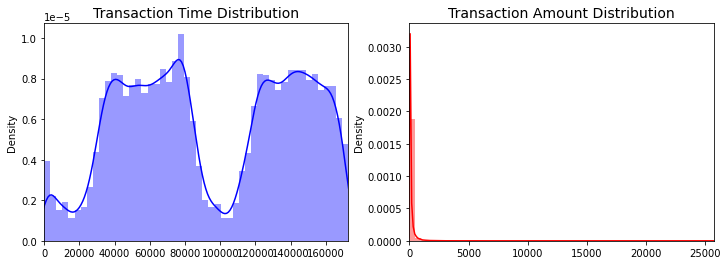

In [8]:
# time & amount distributions
fig, ax = plt.subplots(1, 2, figsize=(12,4))

time_feature = df['Time'].values
amount_feature = df['Amount'].values

sns.distplot(time_feature, ax=ax[0], color='b')
ax[0].set_title('Transaction Time Distribution', fontsize=14)
ax[0].set_xlim([min(time_feature), max(time_feature)])

sns.distplot(amount_feature, ax=ax[1], color='r')
ax[1].set_title('Transaction Amount Distribution', fontsize=14)
ax[1].set_xlim([min(amount_feature), max(amount_feature)])

plt.show()

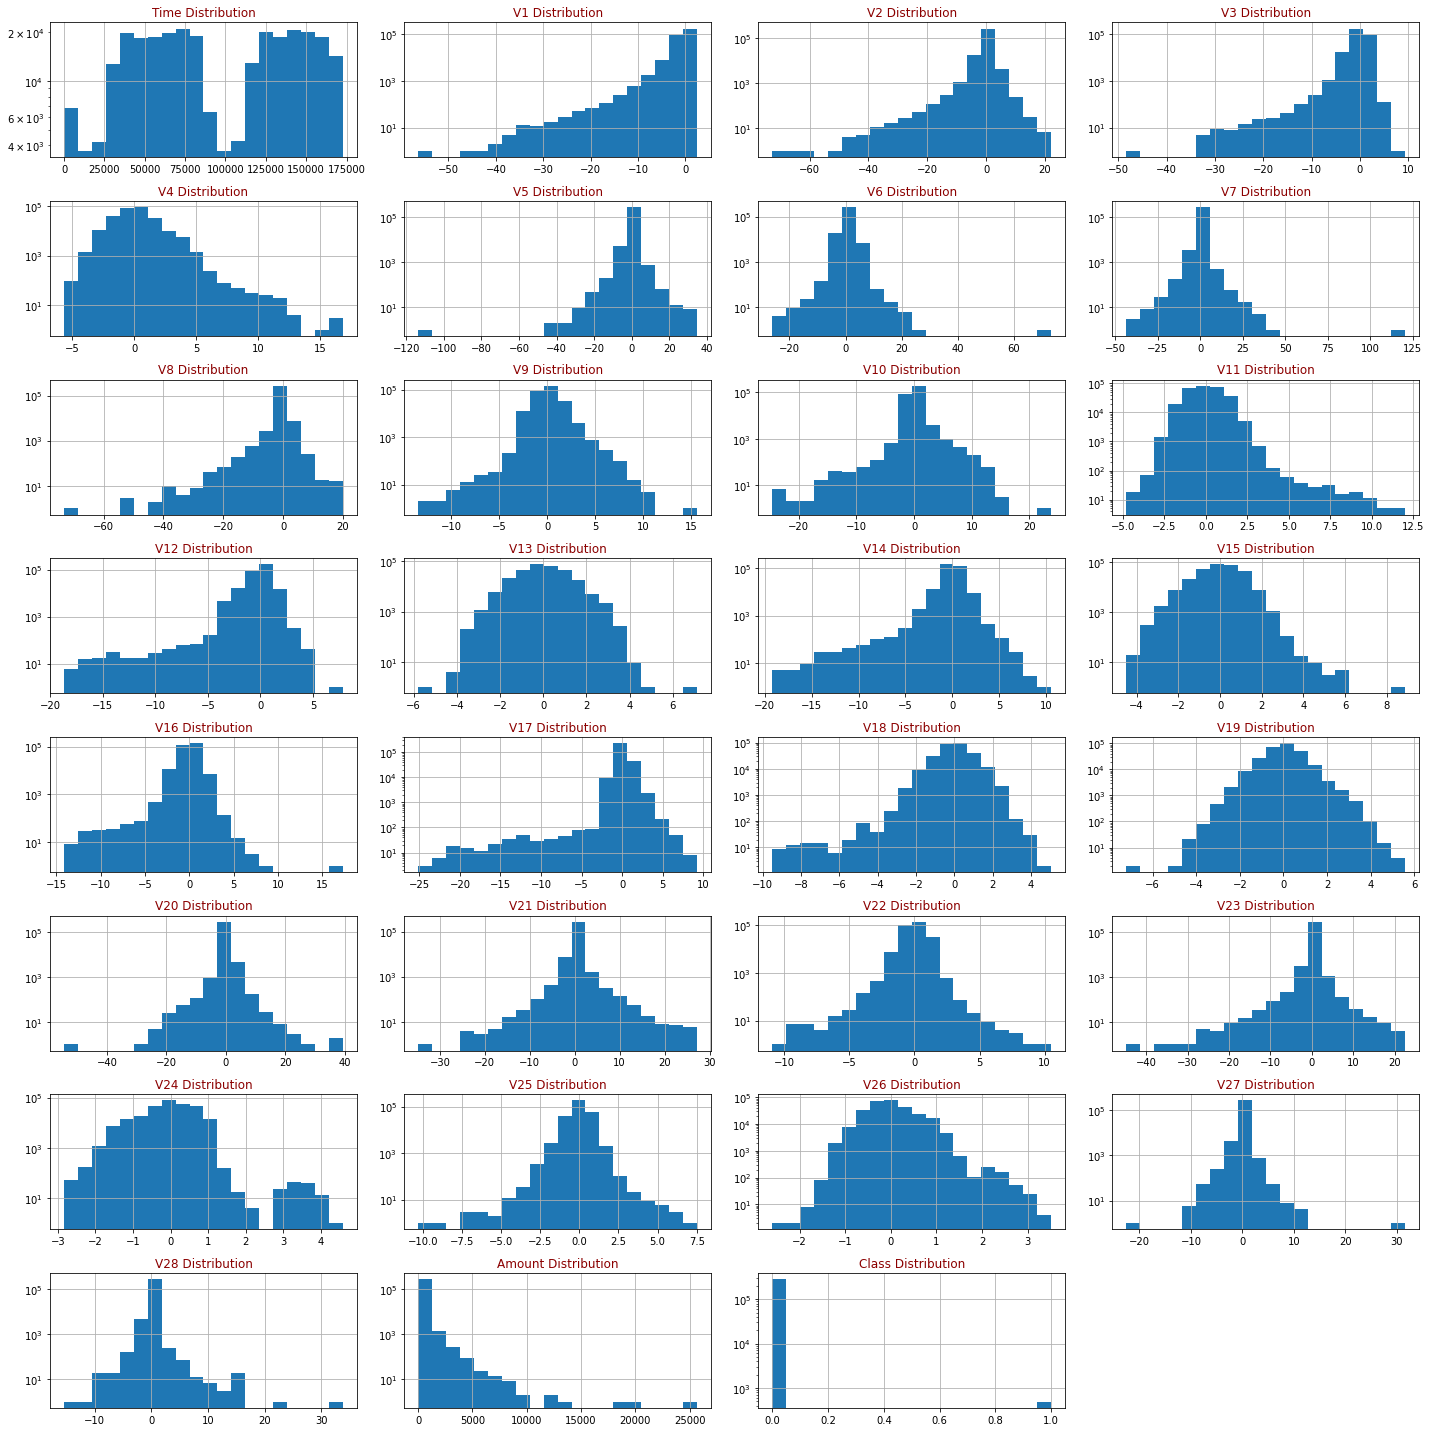

In [9]:
# plot of all features' log distributions
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(20,20))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        dataframe[feature].hist(bins=20,ax=ax)
        ax.set_title(feature+" Distribution",color='DarkRed')
        ax.set_yscale('log')
    fig.tight_layout()
    plt.show()

draw_histograms(df,df.columns,8,4)

In [10]:
# define scalers
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

# scale amount & time
scaled_amount = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
scaled_time = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

In [11]:
# insert the scaled features
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# remove previous unscaled features
df.drop(['Time','Amount'], axis=1, inplace=True)

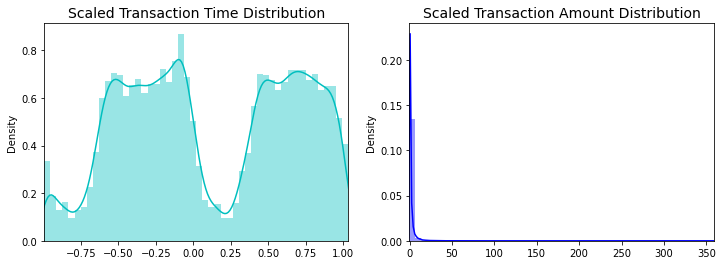

In [12]:
# plot scaled time & amount distributions
fig, ax = plt.subplots(1, 2, figsize=(12,4))

sns.distplot(scaled_time, ax=ax[0], color='c')
ax[0].set_title('Scaled Transaction Time Distribution', fontsize=14)
ax[0].set_xlim([min(scaled_time), max(scaled_time)])

sns.distplot(scaled_amount, ax=ax[1], color='b')
ax[1].set_title('Scaled Transaction Amount Distribution', fontsize=14)
ax[1].set_xlim([min(scaled_amount), max(scaled_amount)])

plt.show()

## Random Search To Optimize XGBoost Parameters

* iterates through all parameters to find the best combination


* number of iterations is set as 3, otherwise the calculation time would be very long


* but in order to find the optimal parameter setting, you should set iterations as 500 and wait overnight

In [32]:
# setting X and y 
y=df['Class']
X=df.drop('Class', axis=1)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

XGBR = xgb.XGBClassifier()

params = {
    
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

n_iter_search = 5 #should be 100
random_search = RandomizedSearchCV(XGBR, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, scoring='neg_mean_squared_error')

random_search.fit(X_train, y_train)

[21:30:17] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves", "subsample_for_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:30:17] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[2

[21:31:24] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves", "subsample_for_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:31:24] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[2

[21:32:45] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:32:58] WARNING: /private/var/folders/b8/fm9sphq57_38t7mgnzjkdvz80000gn/T/pip-install-ppd_o4zb/xgboost_f6827062257e47f88ff132cd08a1f211/build/temp.macosx-11-arm64-3.8/xgboost/src/learner.cc:576: 
Parameters: { "boosting_type", "is_unbalance", "min_child_samples", "num_leaves", "subsample_for_bin" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[2

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                                      0.595959595959596,
                                                      0.601010101010101,
                                   

In [66]:
best_regressor = random_search.best_estimator_

y_pred = best_regressor.predict(X_test)

# Calculate MAE
rmse_pred = mean_absolute_error(y_test, y_pred)

# Get predictions
y_pred_test = best_regressor.predict(X_test)

print(best_regressor)

XGBClassifier(base_score=0.5, booster='gbtree', boosting_type='goss',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6444444444444444, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', is_unbalance=True,
              learning_rate=0.07347459003124081, max_delta_step=0, max_depth=6,
              min_child_samples=155, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_leaves=83, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0.8571428571428571, reg_lambda=0.0,
              scale_pos_weight=1, subsample=0.9797979797979799,
              subsample_for_bin=60000, ...)


# Running each model on the imbalanced dataset

In [43]:
# We create a class, define its objects and create a method
# Upon being called, the method displays the evaluation metrics associated with a particular model 

class Evaluate:
    def __init__(self, algorithm):
        self.algo = algorithm

    def get_score(self, X_test, y_test):
        y_pred = self.algo.predict(X_test)
        print(classification_report(y_test, y_pred))
        R_squared = r2_score(y_test, y_pred)
        print(f'R squared is: {R_squared}')
        accuracy = self.algo.score(X_test, y_test) *100
        print(f'Accuracy is:  {accuracy}')

In [67]:
# We set all the different algorithms in a list which we will be able to iterate through
# At the same time we fill in the model parameters which we'll need 

lr_model = LogisticRegression(max_iter=10000)
rfc_model = RandomForestClassifier(max_depth = 1)
nb_model = GaussianNB()
xgb_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', boosting_type='goss',
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6444444444444444, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', is_unbalance=True,
              learning_rate=0.07347459003124081, max_delta_step=0, max_depth=6,
              min_child_samples=155, min_child_weight=1,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_leaves=83, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0.8571428571428571, reg_lambda=0.0,
              scale_pos_weight=1, subsample=0.9797979797979799,
              subsample_for_bin=60000)
list_models = [lr_model, rfc_model, nb_model, xgb_model]

In [68]:
# split the dataset into a training set and a testing test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# we iterate each model through our 4 models
# for each we fit it the same data that we obtained above, i.e X_train and y_train
# then we set each model as an object of the class Evaluate previously defined
# and we call the get_score method, passing it the fitted models to be ran on X_test against the true output y_test

for model in list_models:
    model.fit(X_train, y_train)
    model_eval = Evaluate(model)

    print(f'\n\nmodel is: {model}')
    model_eval.get_score(X_test, y_test)



model is: LogisticRegression(max_iter=10000)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56858
           1       0.88      0.63      0.74       104

    accuracy                           1.00     56962
   macro avg       0.94      0.82      0.87     56962
weighted avg       1.00      1.00      1.00     56962

R squared is: 0.5472503023727128
Accuracy is:  99.91748885221726


model is: RandomForestClassifier(max_depth=1)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56858
           1       0.88      0.50      0.64       104

    accuracy                           1.00     56962
   macro avg       0.94      0.75      0.82     56962
weighted avg       1.00      1.00      1.00     56962

R squared is: 0.4316546348934054
Accuracy is:  99.89642217618764


model is: GaussianNB()
              precision    recall  f1-score   support

           0       1.00      0.98      0.

# Sampling techniques

### Undersampling

In [69]:
# split class outputs, print initial class counts
df_class_0 = df[df['Class']==0]
df_class_1 = df[df['Class']==1]
count_class_0, count_class_1 = df['Class'].value_counts()
print(df_class_0.shape, df_class_1.shape)

(284315, 31) (492, 31)


In [70]:
# # we return a random sample of class 0 values and of length class 1
df_class_0_undersampling = df_class_0.sample(count_class_1)

# then concatenate it with the initial values of class 1 
df_test_undersampling = pd.concat([df_class_0_undersampling, df_class_1], axis=0)
X_undersampling = df_test_undersampling.drop('Class', axis=1)
y_undersampling = df_test_undersampling['Class']

In [71]:
# split the dataset into a training set and a testing test
X_train, X_test, y_train, y_test = train_test_split(X_undersampling, y_undersampling, test_size=0.2, stratify=y_undersampling)

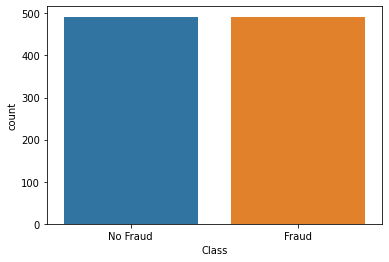

In [72]:
# target class count discrepancies 
P = sns.countplot(df_test_undersampling['Class'])
P.set_xticklabels(['No Fraud','Fraud'])
plt.show()

In [73]:
# iterate again each metrics for each model
for model in list_models:
    model.fit(X_train, y_train)
    model_eval = Evaluate(model)

    print(f'\n\nmodel is: {model}')
    model_eval.get_score(X_test, y_test)



model is: LogisticRegression(max_iter=10000)
              precision    recall  f1-score   support

           0       0.95      0.93      0.94        98
           1       0.93      0.95      0.94        99

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197

R squared is: 0.7563388991960421
Accuracy is:  93.90862944162437


model is: RandomForestClassifier(max_depth=1)
              precision    recall  f1-score   support

           0       0.87      0.99      0.92        98
           1       0.99      0.85      0.91        99

    accuracy                           0.92       197
   macro avg       0.93      0.92      0.92       197
weighted avg       0.93      0.92      0.92       197

R squared is: 0.6751185322613895
Accuracy is:  91.87817258883248


model is: GaussianNB()
              precision    recall  f1-score   support

           0       0.88      0.98      0.

### Oversampling

In [74]:
# reminder of initial class counts
count_class_0, count_class_1

(284315, 492)

In [75]:
# we return a random sample of class 1 values and of length class 0
df_class_1_oversampling = df_class_1.sample(count_class_0, replace=True)
print(df_class_1.shape)

# then concatenate it with the initial values of class 0 
df_test_oversampling=pd.concat([df_class_0, df_class_1_oversampling]) 
print(df_test_oversampling.shape)

(492, 31)
(568630, 31)


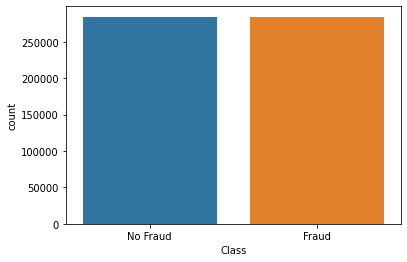

In [76]:
# target class count discrepancies 
P = sns.countplot(df_test_oversampling['Class'])
P.set_xticklabels(['No Fraud','Fraud'])
plt.show()

In [77]:
# define X and y 
X_oversampling = df_test_oversampling.drop('Class', axis=1)
y_oversampling = df_test_oversampling['Class']

In [57]:
# split the dataset into a training set and a testing test
X_train, X_test, y_train, y_test = train_test_split(X_oversampling, y_oversampling, test_size=0.2, stratify=y_oversampling)

In [58]:
# iterate again each metrics for each model
for model in list_models:
    model.fit(X_train, y_train)
    model_eval = Evaluate(model)

    print(f'\n\nmodel is: {model}')
    model_eval.get_score(X_test, y_test)



model is: LogisticRegression(max_iter=10000)
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     56863
           1       0.98      0.92      0.95     56863

    accuracy                           0.95    113726
   macro avg       0.95      0.95      0.95    113726
weighted avg       0.95      0.95      0.95    113726

R squared is: 0.8005733077748272
Accuracy is:  95.01433269437068


model is: RandomForestClassifier(max_depth=1)
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     56863
           1       1.00      0.83      0.91     56863

    accuracy                           0.91    113726
   macro avg       0.93      0.91      0.91    113726
weighted avg       0.93      0.91      0.91    113726

R squared is: 0.6583367040078786
Accuracy is:  91.45841760019697


model is: GaussianNB()
              precision    recall  f1-score   support

           0       0.87      0.97      0.

### SMOTE oversampling

In [59]:
# redefine X and y
X = df.drop('Class', axis=1)
y = df['Class']

In [60]:
# resample X and y 
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

0    284315
1    284315
Name: Class, dtype: int64

In [61]:
# split the dataset into a training set and a testing test
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, stratify=y_sm)

In [62]:
# iterate again each metrics for each model
for model in list_models:
    model.fit(X_train, y_train)
    model_eval = Evaluate(model)

    print(f'\n\nmodel is: {model}')
    model_eval.get_score(X_test, y_test)



model is: LogisticRegression(max_iter=10000)
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     56863
           1       0.97      0.92      0.95     56863

    accuracy                           0.95    113726
   macro avg       0.95      0.95      0.95    113726
weighted avg       0.95      0.95      0.95    113726

R squared is: 0.7946643687459332
Accuracy is:  94.86660921864834


model is: RandomForestClassifier(max_depth=1)
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     56863
           1       1.00      0.85      0.92     56863

    accuracy                           0.92    113726
   macro avg       0.93      0.92      0.92    113726
weighted avg       0.93      0.92      0.92    113726

R squared is: 0.6927351704975115
Accuracy is:  92.31837926243779


model is: GaussianNB()
              precision    recall  f1-score   support

           0       0.87      0.97      0.

# Penalizing the algorithms

In [63]:
# penalize the algorithms by adding balanced class_weight
lr_model = LogisticRegression(max_iter=10000, class_weight="balanced")
rfc_model = RandomForestClassifier(max_depth = 1, class_weight="balanced")
xgb_model = xgb.XGBClassifier(objective='binary:logistic',eval_metric="logloss",seed=42, use_label_encoder=False)
list_models2 = [lr_model, rfc_model, xgb_model]

In [64]:
# iterate again each metrics for each model 
for model in list_models2:
    model.fit(X_train, y_train)
    model_eval = Evaluate(model)

    print(f'\n\nmodel is: {model}')
    model_eval.get_score(X_test, y_test)



model is: LogisticRegression(class_weight='balanced', max_iter=10000)
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     56863
           1       0.97      0.92      0.95     56863

    accuracy                           0.95    113726
   macro avg       0.95      0.95      0.95    113726
weighted avg       0.95      0.95      0.95    113726

R squared is: 0.7946643687459332
Accuracy is:  94.86660921864834


model is: RandomForestClassifier(class_weight='balanced', max_depth=1)
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     56863
           1       1.00      0.85      0.92     56863

    accuracy                           0.92    113726
   macro avg       0.93      0.92      0.92    113726
weighted avg       0.93      0.92      0.92    113726

R squared is: 0.6898510454953133
Accuracy is:  92.24627613738284


model is: XGBClassifier(base_score=0.5, booster='gbtree', colsample_b